# Forest Cover Type Prediction

## Bibliothèques

In [3]:
from urllib.request import urlopen
import os.path as osp
import os
import logging
import gzip
from glob import glob
logging.getLogger().setLevel('INFO')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Activation, Dense
from keras.models import Sequential

Using TensorFlow backend.


## Télécharement des données

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')
    output.write(url.read())
    output.close()

In [3]:
BASE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/'
DATA_DIR = 'covtype'

DATA_URL = BASE_URL + DATA_DIR + "/covtype.data.gz"

os.makedirs(osp.join(DATA_DIR, 'archives'), exist_ok=True)

logging.info("downloading & extracting file %s", DATA_URL)
archive_path = osp.join(DATA_DIR, 'archives', osp.basename(DATA_URL))
download_file(DATA_URL, archive_path)

INFO:root:downloading & extracting file https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz


## Visualisation des données

In [4]:
features_names = {'Elevation':[0],'Aspect':[1],'Slope':[2],
                  'Horizontal_Distance_To_Hydrology':[3],
                  'Vertical_Distance_To_Hydrology':[4],
                  'Horizontal_Distance_To_Roadways':[5],
                  'Hillshade_9am':[6],'Hillshade_Noon':[7],
                  'Hillshade_3pm':[8],
                  'Horiontal_Distance_To_Fire_Points':[9],
                  'Wilderness_Area':[10,11,12,13],
                  'Soil_Type':list(range(14,54)),
                  'Cover_Type':[54]}

def convert_to_listofint(df_attribut):
    return [[int(x) for x in X.split()] for X in df_attribut]

def convert_to_int(df_attribut):
    return [int(x) for x in df_attribut]

df_covtype = pd.read_csv('covtype/archives/covtype.data.gz',
                         header=None,
                         parse_dates=features_names,
                         compression='gzip')

for attribut in features_names:
    if attribut in ['Wilderness_Area','Soil_Type']:
        df_covtype[attribut] = convert_to_listofint(df_covtype[attribut])
    else:
        df_covtype[attribut] = convert_to_int(df_covtype[attribut])

In [5]:
df_covtype.groupby('Cover_Type').mean()

,Horizontal_Distance_To_Roadways,Aspect,Horiontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology,Elevation,Hillshade_9am,Slope,Hillshade_Noon,Hillshade_3pm,Vertical_Distance_To_Hydrology
Cover_Type,,,,,,,,,,
1,2614.834517,156.138227,2009.253517,270.555245,3128.644888,211.998782,13.127110,223.430211,143.875038,42.156939
2,2429.530799,152.060515,2168.154849,279.916442,2920.936061,213.844423,13.550499,225.326596,142.983466,45.884219
3,943.940734,176.372490,910.955949,210.276473,2394.509845,201.918415,20.770208,215.826537,140.367176,62.446915
4,914.199490,137.139425,859.124135,106.934838,2223.939934,228.345832,18.528941,216.997088,111.392792,41.186749
5,1349.765722,139.283051,1577.719794,212.354893,2787.417571,223.474876,16.641315,219.035816,121.920889,50.610344
6,1037.169805,180.539068,1055.351471,159.853458,2419.181897,192.844302,19.048886,209.827662,148.284044,45.437439
7,2738.250463,153.236226,2070.031594,356.994686,3361.928669,216.967723,14.255924,221.746026,134.932033,69.474305


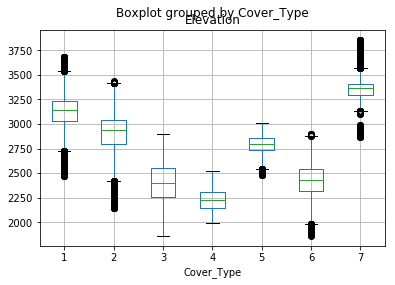

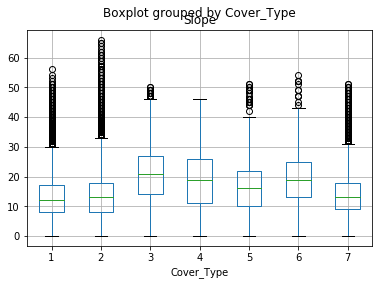

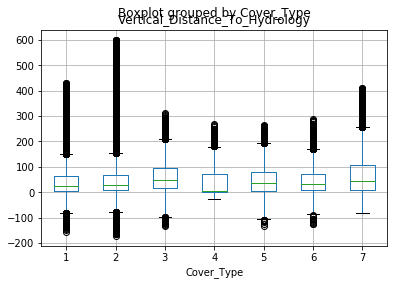

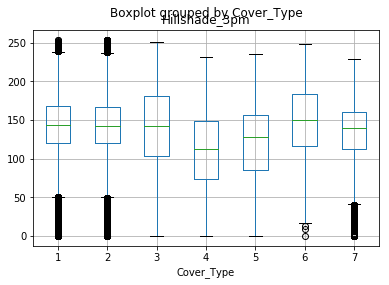

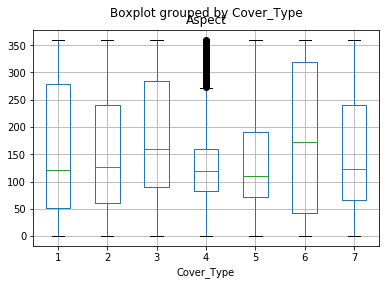

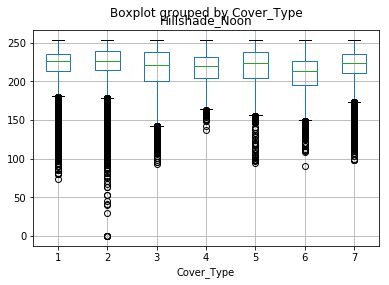

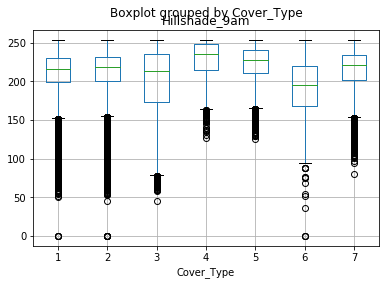

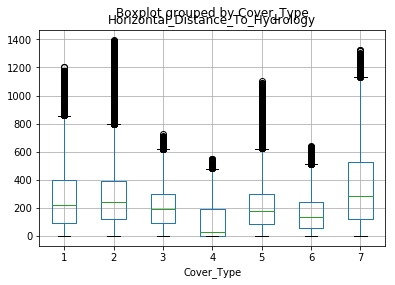

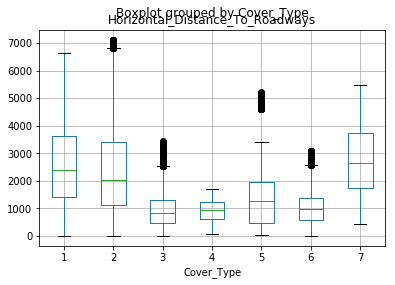

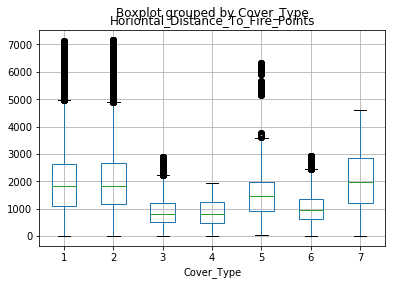

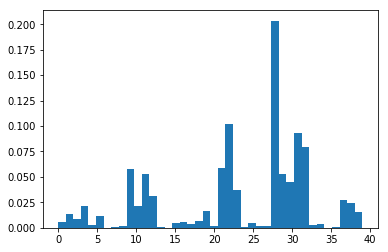

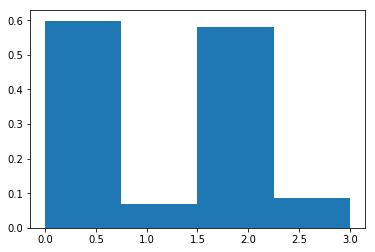

In [6]:
for attribut in features_names:
    if attribut in ['Wilderness_Area','Soil_Type']:
        histogram = [x.index(1) for x in df_covtype[attribut]]
        plt.hist(histogram,density=True,
                 bins=len(df_covtype[attribut][0]))
        plt.show()
    elif not(attribut is 'Cover_Type'):
        df_covtype.boxplot(column=attribut,by='Cover_Type')
        df_covtype[attribut] /= max(df_covtype[attribut]) #Normalisation
        plt.show()

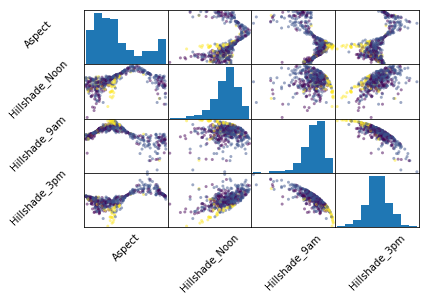

In [7]:
sm = scatter_matrix(df_covtype[['Aspect','Hillshade_Noon',
                                'Hillshade_9am','Hillshade_3pm']][:500],
               c=df_covtype.Cover_Type.values[:500])

#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(45) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]
plt.show()

On peut voir que les données sont corrélées. On peut potentiellement réduire le nombre d'attributs.

## Données de train/validation/test

In [6]:
data = df_covtype.drop(['Cover_Type','Wilderness_Area','Soil_Type'],axis=1).values
target = df_covtype.Cover_Type.values

# Ensemble de train et ensemble de test
(x_train,x_test,y_train,y_test) = train_test_split(data,target,
                                                  random_state=0,
                                                  test_size=.1)

# Ensemble de validation 
(x_train,x_valid,y_train,y_valid) = train_test_split(x_train,
                                                     y_train,
                                                     test_size=.11)

print("x_train shape:", x_train.shape, 
      "y_train shape:", y_train.shape)
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

x_train shape: (465389, 10) y_train shape: (465389,)
465389 train set
57521 validation set
58102 test set


## Train

In [ ]:
clf = svm.SVC()
clf.fit(x_train,y_train)

In [ ]:
predicted = svm_clf.predict(y_valid)
print('Matrice de confusion :\n',confusion_matrix(y_valid,predicted))
print(classification_report(y_valid,predicted))    